# SWB Regression Pipeline - Theta Power 
Created: 07/30/24 \
Updated: 09/25/2024 \
*ran with 1sec regression dfs from 09/25/2024*

In [2]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp, pearsonr, spearmanr
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.mixed_linear_model import MixedLM 
from joblib import Parallel, delayed
import pickle
import itertools
import time 
from matplotlib.ticker import StrMethodFormatter
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import matplotlib as mpl
from matplotlib import cm
import patsy
from statsmodels.api import OLS
from scipy import stats
from tqdm import tqdm
from sklearn.linear_model import RANSACRegressor



import warnings
warnings.filterwarnings('ignore')




In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# Specify root directory for un-archived data and results 
base_dir   = '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/'
anat_dir   = f'{base_dir}recon_labels/'
neural_dir = f'{base_dir}data/'
save_dir   = f'{base_dir}results/regression_data/'
fig_dir    = f'{base_dir}figs/regression_figs/'
script_dir = '/hpc/users/finka03/swb_ephys_analysis/scripts/'


date = datetime.date.today().strftime('%m%d%Y')
print(date)



09252024


In [5]:
import sys
sys.path.append(f'{base_dir}LFPAnalysis/')

from LFPAnalysis import analysis_utils

sys.path.append(f'{script_dir}analysis_notebooks/')

from ieeg_tools import *
from plot_tools import *

In [6]:
subj_ids = list(pd.read_excel(f'{base_dir}subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[0]).PatientID)
n_subj = len(subj_ids)
# subj_ids


In [7]:
bdi_list = pd.read_excel(f'{base_dir}subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[3])
bdi_list = list(bdi_list.SWB_BDI)
subj_info_df = pd.DataFrame({'subj_id':subj_ids,'bdi':bdi_list})
subj_info_df



,subj_id,bdi
0,MS002,14
1,MS003,8
2,MS009,16
3,MS011,13
4,MS015,26
5,MS016,10
6,MS017,26
7,MS019,12
8,MS022,10
9,MS024,16


In [7]:
# #### set theme for all plots
# # %matplotlib inline
# # from matplotlib import rc
# # rc('text', usetex=False)

# sns.set_theme(style='ticks') 
# sns.set_context("poster")



In [8]:
# from matplotlib.colors import ListedColormap,LinearSegmentedColormap
# import matplotlib as mpl
# from matplotlib import cm


# # saez_cmap colors = org,yellow, sagegreen, darker green, blue, purple 

# # 671351
# saez_colors    = ['#ffb243','#FCE27C','#6a9752','#1d5d2a','#00467e','#561C46']
# saez_hex_cmap  = ListedColormap(saez_colors)
# saez_rgb       = [mpl.colors.to_rgb(hex) for hex in saez_colors]
# saez_full_cmap = LinearSegmentedColormap.from_list('saez_full_cmap',saez_rgb,N=10)
# #plot_palette = saez_linear_cmap.resampled(lutsize=30)
# expanded_cmap  = [mpl.colors.rgb2hex(saez_full_cmap(c)[:3]) for c in range(saez_full_cmap.N)]


# Load beta power data 

In [8]:
epoch_len = '1sec'

In [9]:
band = 'theta'
theta_df = pd.read_csv(f'{save_dir}{band}_master_df_{epoch_len}.csv')
theta_df.subj_id.unique()

array(['MS002', 'MS003', 'MS009', 'MS011', 'MS015', 'MS016', 'MS017',
       'MS019', 'MS022', 'MS024', 'MS025', 'MS026', 'MS027', 'MS028',
       'MS029', 'MS030', 'MS033', 'MS035', 'MS041', 'MS043', 'MS048',
       'MS050', 'DA8', 'DA023', 'DA026', 'DA037', 'DA039'], dtype=object)

In [10]:
roi_reref_labels_master_df = pd.read_csv(
    glob(f'{base_dir}results/roi_info/roi_reref_labels_master.csv')[0])
roi_reref_labels_master_df = roi_reref_labels_master_df.drop(columns=['Unnamed: 0'])




In [11]:
roi_reref_labels_master_df.roi.value_counts()

roi
dmpfc            225
ofc              202
acc              193
sts              155
hpc              135
amy              113
dlpfc            107
temporal         105
vlpfc             82
ains              71
pins              60
thalamus          58
temporal pole     31
mcc               28
phg               25
motor             25
parietal          24
vmpfc             23
caudate            8
pcc                1
Name: count, dtype: int64

In [12]:
# keep_rois = roi_reref_labels_master_df.roi.value_counts().index[
#     roi_reref_labels_master_df.roi.value_counts().values>=50].tolist()
keep_rois = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins','acc','amy','hpc']     

keep_rois


['dlpfc', 'vlpfc', 'dmpfc', 'ofc', 'ains', 'pins', 'acc', 'amy', 'hpc']

In [13]:
# ####### NEW DATA FRAME 
theta_reg_df = theta_df.copy()
theta_reg_df = theta_reg_df[theta_reg_df.roi.isin(keep_rois)]

# Test Single Electrode Regressions 

In [14]:
elec_col    = 'unique_reref_ch'
main_var    = 'cpe'
reg_formula = 'band_pow~GambleChoice+TotalProfit+cpe'
# n_permutations = 1000
# results_dict, main_var_sig = run_individual_elec_regression(theta_reg_df,reg_formula,
#                                                             elec_col, main_var,n_permutations)



In [14]:
# save_vars = results_dict['MS002_lacas1-lacas2'].index.tolist()
# save_vars


['Intercept', 'GambleChoice[T.safe]', 'TotalProfit', 'cpe']

In [15]:
# results = single_elec_permutation_results(results_dict,theta_df,save_vars)
# results



,unique_elec_id,subj_id,roi,bdi,Original_Estimate_Intercept,Original_Estimate_GambleChoice[T.safe],Original_Estimate_TotalProfit,Original_Estimate_cpe,Permuted_Mean_Intercept,Permuted_Mean_GambleChoice[T.safe],...,Permuted_Std_TotalProfit,Permuted_Std_cpe,Z_Score_Intercept,Z_Score_GambleChoice[T.safe],Z_Score_TotalProfit,Z_Score_cpe,P_Value_Intercept,P_Value_GambleChoice[T.safe],P_Value_TotalProfit,P_Value_cpe
0,MS002_lacas1-lacas2,MS002,acc,14,0.169032,-0.130500,0.133198,0.013479,0.075270,5.299064e-03,...,0.069075,0.063265,1.934623,-1.943081,1.919822,0.246188,0.053037,0.052006,0.054880,0.805537
1,MS002_lacas2-lacas3,MS002,acc,14,0.040159,0.061934,0.161376,0.059414,0.084988,-2.132827e-03,...,0.078816,0.076623,-0.730332,0.724015,2.068203,0.811818,0.465188,0.469057,0.038621,0.416896
2,MS002_lacas3-lacas4,MS002,acc,14,0.079186,0.043637,-0.039636,-0.007299,0.109195,2.000524e-04,...,0.064349,0.063382,-0.606392,0.608812,-0.629146,-0.116452,0.544254,0.542649,0.529253,0.907294
3,MS002_lacas4-lacas5,MS002,acc,14,0.075493,0.006586,0.055807,0.012780,0.080250,8.069840e-07,...,0.074220,0.071887,-0.091329,0.087693,0.791077,0.152332,0.927231,0.930120,0.428899,0.878925
4,MS002_lacas5-lacas6,MS002,acc,14,0.149164,0.028271,-0.018270,0.016682,0.166096,3.627774e-03,...,0.079795,0.080097,-0.289391,0.292178,-0.238390,0.246625,0.772282,0.770150,0.811579,0.805198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1183,DA039_rpins1-rpins2,DA039,pins,22,0.148494,-0.020758,-0.162079,-0.020309,0.142709,4.730018e-04,...,0.078279,0.079438,0.176196,-0.258279,-2.013249,-0.314170,0.860140,0.796192,0.044088,0.753392
1184,DA039_rpins2-rpins3,DA039,pins,22,0.009071,0.065821,-0.185486,0.087116,0.039185,1.978382e-03,...,0.063348,0.064248,-1.124278,0.949961,-2.921273,1.355214,0.260895,0.342132,0.003486,0.175349
1185,DA039_rpins3-rpins4,DA039,pins,22,-0.001851,0.021706,-0.067873,0.017747,0.008775,-1.082194e-03,...,0.069989,0.068413,-0.391866,0.336065,-0.993792,0.244578,0.695157,0.736822,0.320324,0.806783
1186,DA039_rsgcc6-rsgcc7,DA039,vlpfc,22,-0.119792,0.121094,-0.017200,-0.020749,-0.070273,-3.018872e-03,...,0.062595,0.060232,-2.020145,2.022904,-0.278595,-0.343427,0.043368,0.043083,0.780556,0.731277


In [16]:
# # # create a binary pickle file 
# pickle.dump(results,
#             open(f'{save_dir}single_elec_regression_{band}_{reg_formula}_{epoch_len}_{date}.pkl',"wb"))




In [15]:
results = pickle.load(open(f'{save_dir}single_elec_regression_theta_band_pow~GambleChoice+TotalProfit+cpe_1sec_09252024.pkl',"rb"))



In [16]:
# sig_data = results[results.unique_elec_id.isin(main_var_sig)]
# sig_data

sig_data = results[results['P_Value_cpe']<0.05]
sig_data




,unique_elec_id,subj_id,roi,bdi,Original_Estimate_Intercept,Original_Estimate_GambleChoice[T.safe],Original_Estimate_TotalProfit,Original_Estimate_cpe,Permuted_Mean_Intercept,Permuted_Mean_GambleChoice[T.safe],...,Permuted_Std_TotalProfit,Permuted_Std_cpe,Z_Score_Intercept,Z_Score_GambleChoice[T.safe],Z_Score_TotalProfit,Z_Score_cpe,P_Value_Intercept,P_Value_GambleChoice[T.safe],P_Value_TotalProfit,P_Value_cpe
22,MS002_lhplt1-lhplt2,MS002,hpc,14,-0.049450,0.180278,0.059045,0.195113,0.076634,-0.002379,...,0.079990,0.075731,-2.188286,2.199793,0.735646,2.570646,0.028649,0.027822,0.461946,0.010151
26,MS002_lloif1-lloif2,MS002,ofc,14,0.296594,-0.101298,0.135907,0.190827,0.228751,-0.004007,...,0.082129,0.083625,1.098604,-1.093343,1.625302,2.276392,0.271941,0.274243,0.104098,0.022823
36,MS002_lmoif11-lmoif12,MS002,vlpfc,14,-0.009809,0.008246,-0.035655,0.147249,-0.005741,0.001226,...,0.059440,0.058296,-0.092452,0.110624,-0.570574,2.472725,0.926339,0.911914,0.568288,0.013409
48,MS002_racas1-racas2,MS002,acc,14,0.021595,-0.017455,0.062877,0.140388,0.008477,0.000864,...,0.062777,0.061367,0.278444,-0.269779,0.958984,2.304877,0.780671,0.787330,0.337567,0.021173
51,MS002_racas6-racas7,MS002,dmpfc,14,0.079067,0.118632,0.039039,0.197019,0.159595,0.001511,...,0.082428,0.078964,-1.345459,1.357153,0.485668,2.480801,0.178477,0.174733,0.627203,0.013109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1158,DA039_rains2-rains3,DA039,ains,22,-0.171034,0.192040,-0.024303,-0.141719,-0.095384,-0.001253,...,0.070483,0.067036,-2.565649,2.613510,-0.328965,-2.062615,0.010298,0.008962,0.742182,0.039149
1159,DA039_rains3-rains4,DA039,ains,22,-0.100618,0.142170,-0.112942,-0.168156,-0.045006,0.002481,...,0.081903,0.076056,-1.759840,1.762363,-1.378347,-2.203877,0.078435,0.078008,0.168096,0.027533
1160,DA039_rains4-rains5,DA039,ains,22,-0.037117,-0.007344,-0.022296,-0.134819,-0.040694,-0.001691,...,0.070543,0.066194,0.124746,-0.078903,-0.333884,-2.035458,0.900725,0.937110,0.738467,0.041805
1172,DA039_rof1-rof2,DA039,ofc,22,-0.120778,0.115413,-0.100444,-0.138921,-0.074833,0.000440,...,0.058544,0.059711,-1.913435,1.906495,-1.763059,-2.340327,0.055692,0.056586,0.077891,0.019267


In [17]:
sig_data.roi.value_counts()



roi
ofc      16
hpc      14
acc      14
dmpfc    13
dlpfc     9
ains      9
vlpfc     6
pins      4
amy       3
Name: count, dtype: int64

In [18]:
sig_data.roi.unique()



array(['hpc', 'ofc', 'vlpfc', 'acc', 'dmpfc', 'dlpfc', 'ains', 'pins',
       'amy'], dtype=object)

In [19]:
# bar_order = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins', 'acc','hpc','amy']
bar_order = keep_rois.copy()

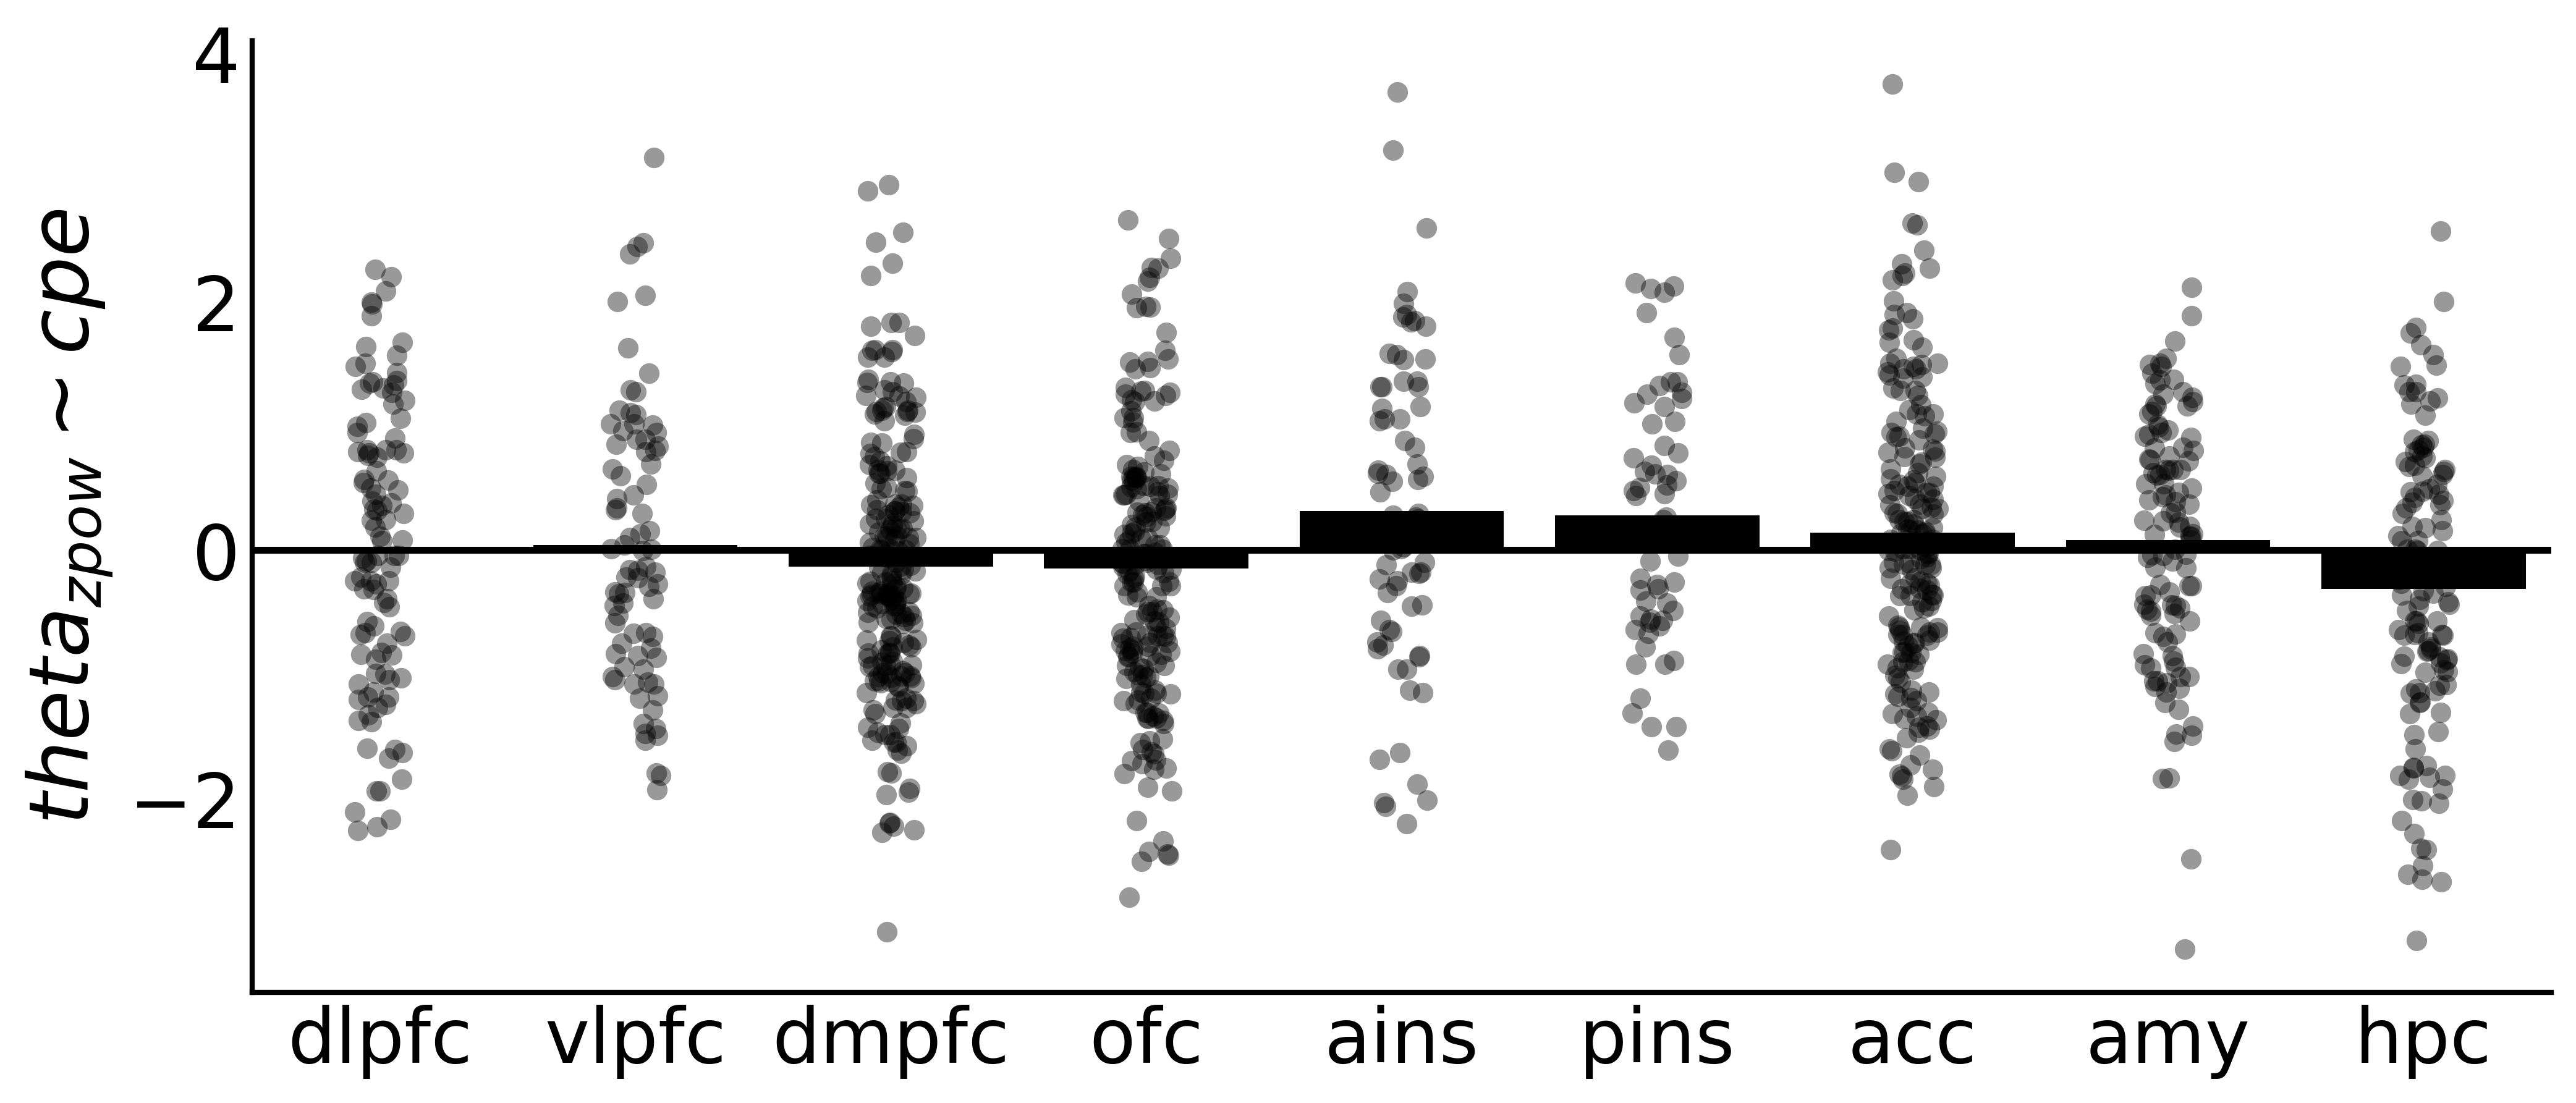

In [20]:

ylabel = fr'${band}_{{zpow}} \sim cpe$'
fig_id = f'{band}_single_elec_roi_barplot_{epoch_len}.pdf'

plot_roi_model_results(results,'roi','Z_Score_cpe',bar_order=bar_order,figsize=(12,5),color='k',
                       ylabel=ylabel,save_fig=True,save_dir=save_dir,fig_id=fig_id,dpi=400)





In [21]:
# results.to_csv(f'{save_dir}{band}_single_elec_perm_results_{epoch_len}.csv')


In [22]:
results.groupby('roi').agg('mean',numeric_only=True)['Z_Score_cpe'][bar_order]



roi
dlpfc    0.019997
vlpfc    0.040722
dmpfc   -0.134176
ofc     -0.146411
ains     0.315692
pins     0.281884
acc      0.138611
amy      0.082167
hpc     -0.313908
Name: Z_Score_cpe, dtype: float64

In [23]:
single_elec_res = results.copy()[results.roi.isin(bar_order)]
single_elec_res



,unique_elec_id,subj_id,roi,bdi,Original_Estimate_Intercept,Original_Estimate_GambleChoice[T.safe],Original_Estimate_TotalProfit,Original_Estimate_cpe,Permuted_Mean_Intercept,Permuted_Mean_GambleChoice[T.safe],...,Permuted_Std_TotalProfit,Permuted_Std_cpe,Z_Score_Intercept,Z_Score_GambleChoice[T.safe],Z_Score_TotalProfit,Z_Score_cpe,P_Value_Intercept,P_Value_GambleChoice[T.safe],P_Value_TotalProfit,P_Value_cpe
0,MS002_lacas1-lacas2,MS002,acc,14,0.169032,-0.130500,0.133198,0.013479,0.075270,5.299064e-03,...,0.069075,0.063265,1.934623,-1.943081,1.919822,0.246188,0.053037,0.052006,0.054880,0.805537
1,MS002_lacas2-lacas3,MS002,acc,14,0.040159,0.061934,0.161376,0.059414,0.084988,-2.132827e-03,...,0.078816,0.076623,-0.730332,0.724015,2.068203,0.811818,0.465188,0.469057,0.038621,0.416896
2,MS002_lacas3-lacas4,MS002,acc,14,0.079186,0.043637,-0.039636,-0.007299,0.109195,2.000524e-04,...,0.064349,0.063382,-0.606392,0.608812,-0.629146,-0.116452,0.544254,0.542649,0.529253,0.907294
3,MS002_lacas4-lacas5,MS002,acc,14,0.075493,0.006586,0.055807,0.012780,0.080250,8.069840e-07,...,0.074220,0.071887,-0.091329,0.087693,0.791077,0.152332,0.927231,0.930120,0.428899,0.878925
4,MS002_lacas5-lacas6,MS002,acc,14,0.149164,0.028271,-0.018270,0.016682,0.166096,3.627774e-03,...,0.079795,0.080097,-0.289391,0.292178,-0.238390,0.246625,0.772282,0.770150,0.811579,0.805198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1183,DA039_rpins1-rpins2,DA039,pins,22,0.148494,-0.020758,-0.162079,-0.020309,0.142709,4.730018e-04,...,0.078279,0.079438,0.176196,-0.258279,-2.013249,-0.314170,0.860140,0.796192,0.044088,0.753392
1184,DA039_rpins2-rpins3,DA039,pins,22,0.009071,0.065821,-0.185486,0.087116,0.039185,1.978382e-03,...,0.063348,0.064248,-1.124278,0.949961,-2.921273,1.355214,0.260895,0.342132,0.003486,0.175349
1185,DA039_rpins3-rpins4,DA039,pins,22,-0.001851,0.021706,-0.067873,0.017747,0.008775,-1.082194e-03,...,0.069989,0.068413,-0.391866,0.336065,-0.993792,0.244578,0.695157,0.736822,0.320324,0.806783
1186,DA039_rsgcc6-rsgcc7,DA039,vlpfc,22,-0.119792,0.121094,-0.017200,-0.020749,-0.070273,-3.018872e-03,...,0.062595,0.060232,-2.020145,2.022904,-0.278595,-0.343427,0.043368,0.043083,0.780556,0.731277


In [24]:

single_rho_data = []
single_sig_rho = []

# BDI CORRELATIONS
for roi in single_elec_res.roi.unique().tolist():
    roi_temp_data = single_elec_res[single_elec_res.roi==roi]
    rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.Z_Score_cpe)
#     rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.elec_bCPE)
#     print(f'{roi} pearsonr',rho,rho_p)
#     fe_results['rho'][fe_results.roi==roi]   = rho
#     fe_results['rho_p'][fe_results.roi==roi] = rho_p
    
    single_rho_data.append(pd.DataFrame({'roi':roi,'rho':rho,'rho_p':np.round(rho_p,4)},index=[0]))
#     if rho_p <= bonferr_alpha:
#         sig_bdi_rois.append(roi)
#     if rho_p < bonferr_alpha:
    if rho_p < 0.05:
        single_sig_rho.append((roi,rho,rho_p))
#     print(f'{roi} pearsonr',rho,rho_p)

single_rho_data = pd.concat(single_rho_data).reset_index(drop=True)



In [25]:
agg_single_results = single_elec_res.groupby('roi').agg('mean',numeric_only=True)[['Z_Score_cpe']].copy()

agg_single_results


,Z_Score_cpe
roi,
acc,0.138611
ains,0.315692
amy,0.082167
dlpfc,0.019997
dmpfc,-0.134176
hpc,-0.313908
ofc,-0.146411
pins,0.281884
vlpfc,0.040722


In [26]:
single_rho_data = single_rho_data.set_index('roi')
single_rho_data['Z_Score_cpe'] = agg_single_results.Z_Score_cpe
single_rho_data[['Z_Score_cpe','rho','rho_p']]



,Z_Score_cpe,rho,rho_p
roi,,,
acc,0.138611,-0.002161,0.9762
dmpfc,-0.134176,0.038515,0.5655
amy,0.082167,0.018849,0.8429
ains,0.315692,-0.204424,0.0873
vlpfc,0.040722,-0.258355,0.0191
hpc,-0.313908,-0.135837,0.1162
ofc,-0.146411,-0.149373,0.0339
pins,0.281884,-0.119462,0.3633
dlpfc,0.019997,0.190736,0.0491


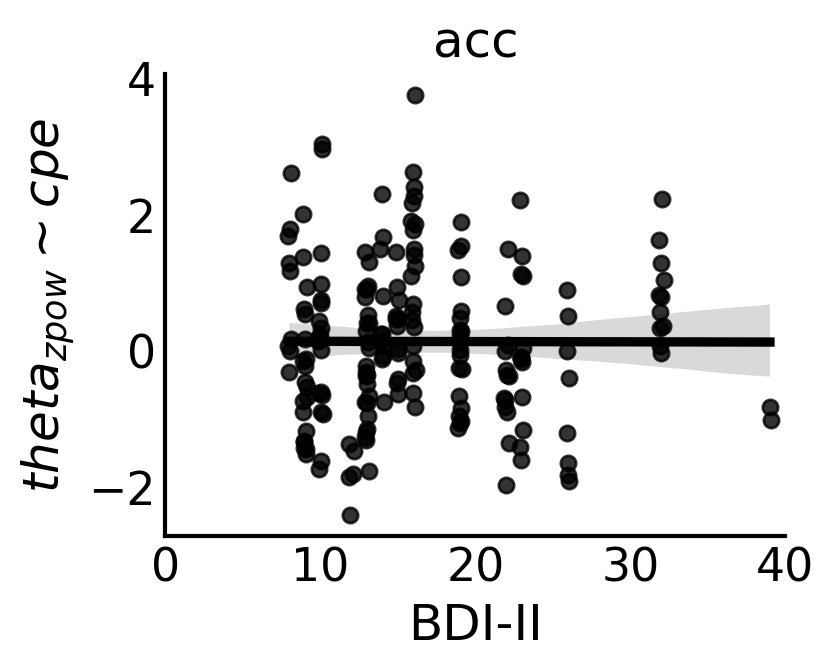

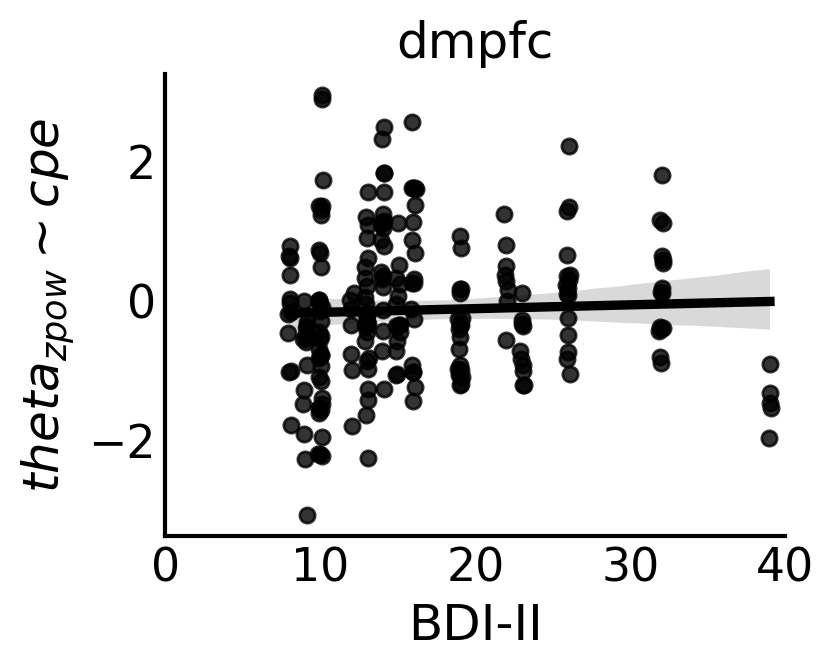

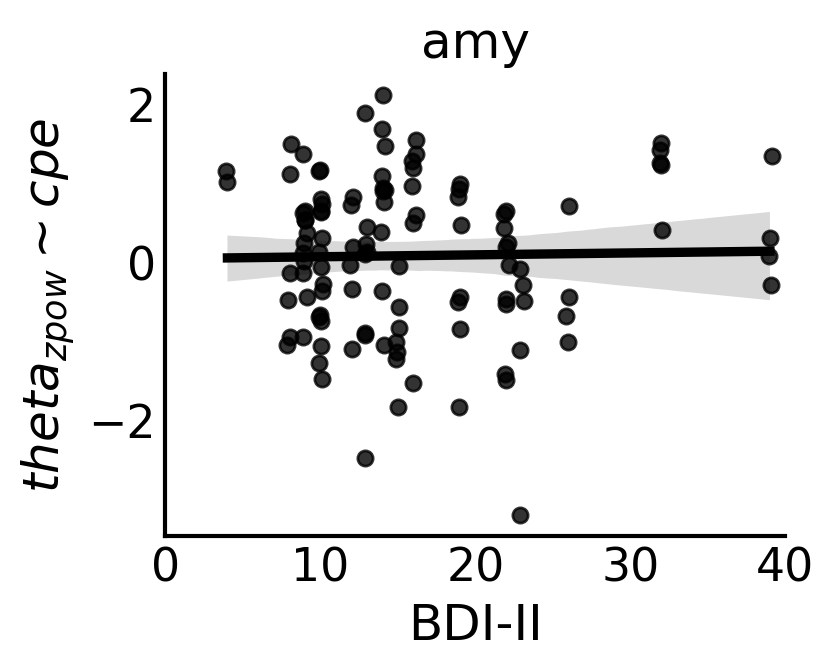

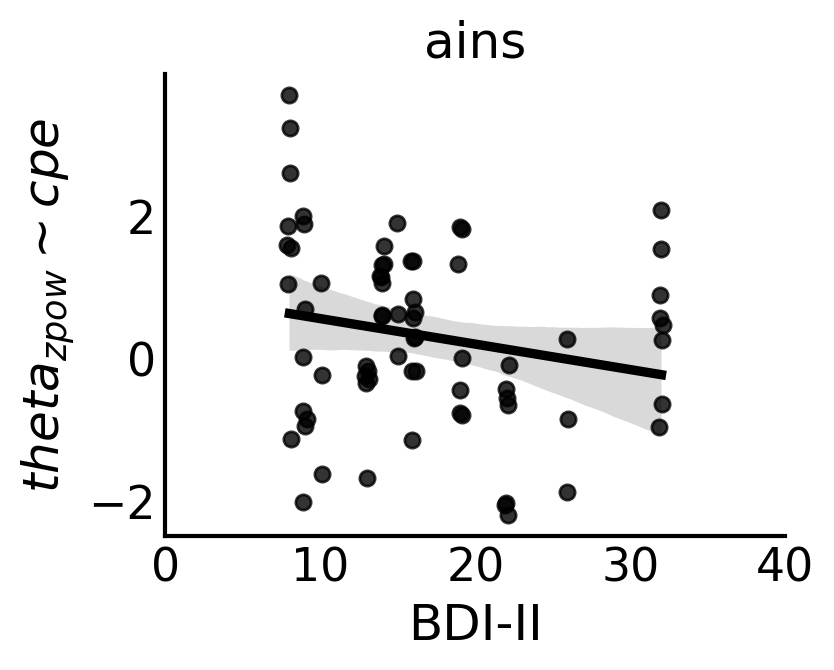

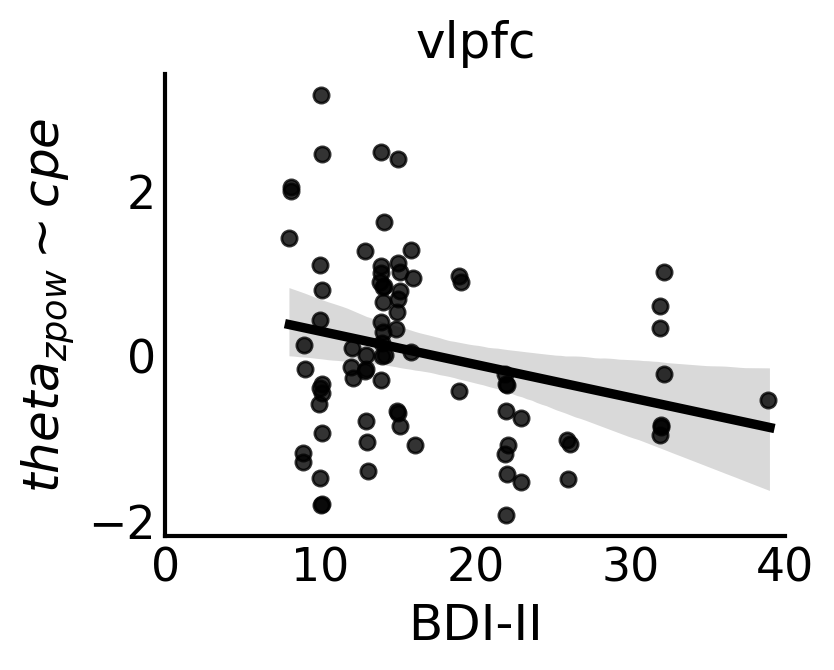

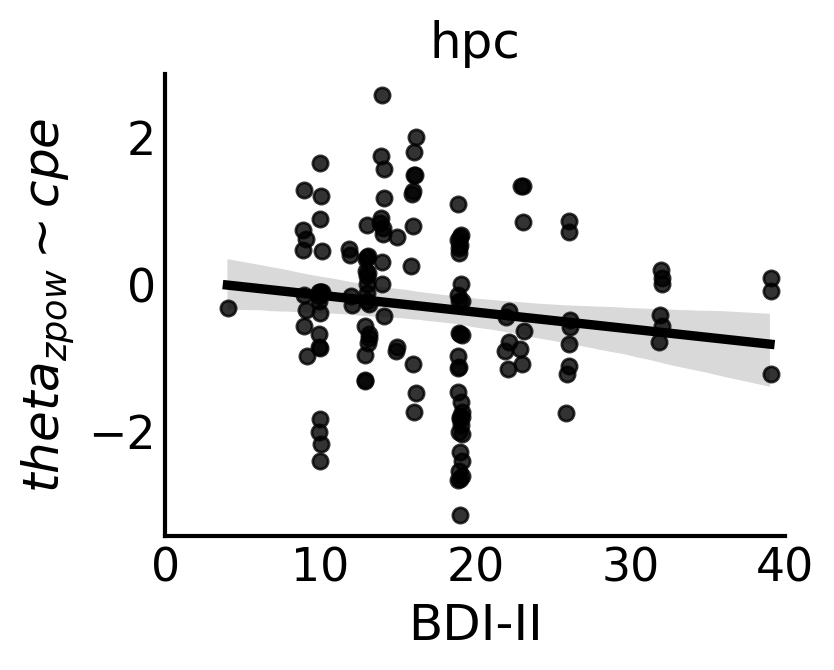

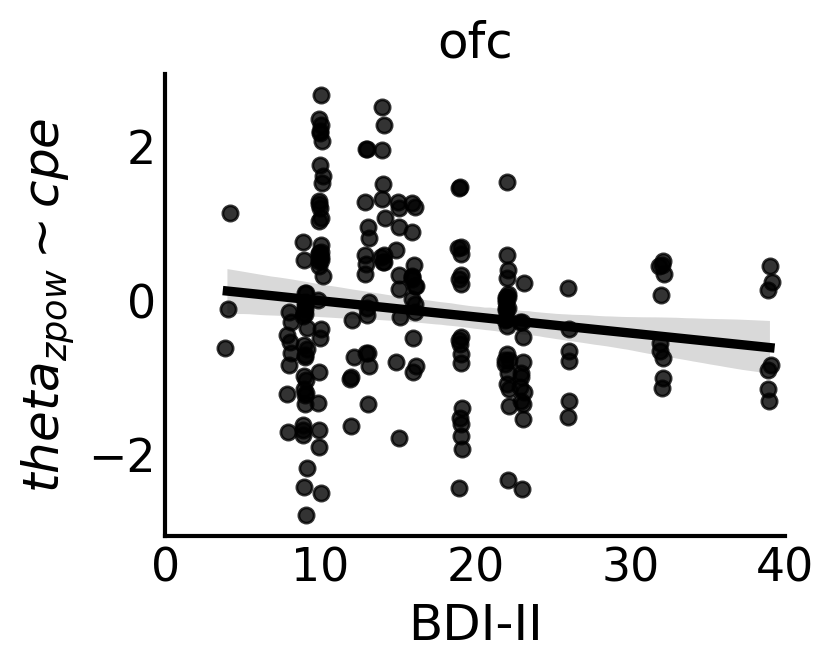

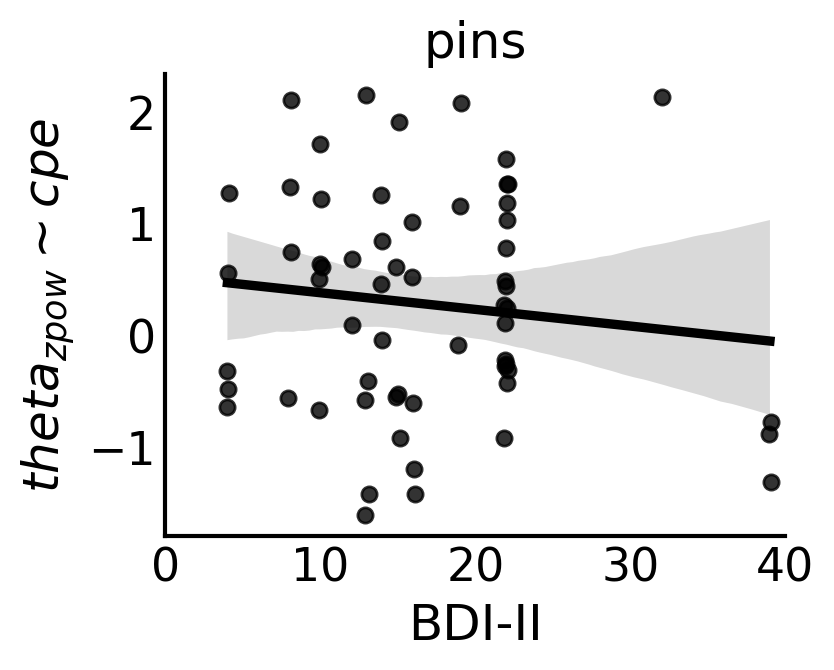

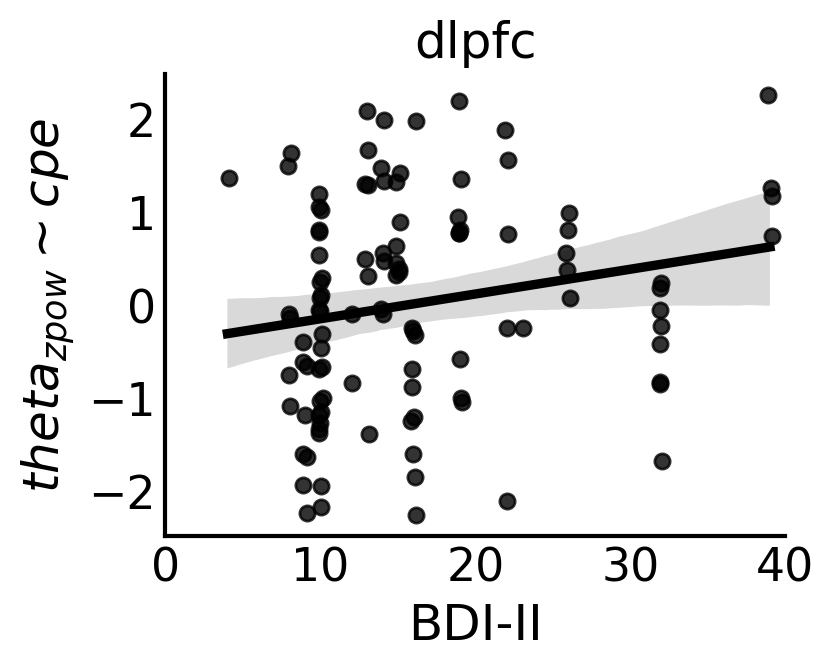

In [27]:
sns.set_context("talk",rc={'axes.linewidth': 1.5})

for roi in single_elec_res.roi.unique().tolist():
    
    roi_temp_data = single_elec_res[single_elec_res.roi==roi]
    
    corr_fig_id = f'{band}_{roi}_bdi_cpe_coeff_scatter_{epoch_len}.pdf'
        
    fig,ax = plt.subplots(1,1,figsize=(4,3),dpi=200)

    sns.regplot(data=roi_temp_data,x='bdi',y='Z_Score_cpe',scatter=True,ci=95,
                fit_reg=True,color = 'k',x_jitter = 0.15,scatter_kws={'s':30}) #034975

    
    plt.xlabel('BDI-II')
    plt.xlim([0,40])
    
    plt.tick_params(length=0) 
    plt.ylabel(fr'${band}_{{zpow}} \sim cpe$')


    plt.title(f'{roi}')
    sns.despine()
    
    
    plt.savefig(f'{save_dir}{corr_fig_id}', format=corr_fig_id.split('.')[-1], metadata=None,
        bbox_inches='tight', pad_inches=0.1,dpi=400,
        facecolor='auto', edgecolor='auto',
        backend=None)


### Test BDI Correlations via robust regression

In [28]:
### robust regression bdi ~ cpe coefficients
roi_rlm_dict = {}

for roi in single_elec_res.roi.unique().tolist():
    roi_df = single_elec_res[single_elec_res.roi == roi]
    rlm = sm.RLM(roi_df.bdi.values, sm.add_constant(roi_df.Z_Score_cpe.values), M=sm.robust.norms.HuberT())
    rlm_results = rlm.fit()
    roi_rlm_dict[roi] = rlm_results
    print(roi)
    print(rlm_results.summary())




acc
                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                  193
Model:                            RLM   Df Residuals:                      191
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 25 Sep 2024                                         
Time:                        12:33:05                                         
No. Iterations:                    17                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.9421      0.452     35.233     

# Mixed effects models

In [35]:
outcome_var  = 'band_pow'
rand_eff_var = 'unique_reref_ch'
reg_vars     = ['GambleChoice','TotalProfit', 'cpe']
rand_vars    = ['GambleChoice','TotalProfit', 'cpe']


In [36]:
roi_fit_dict = {f'{roi}':fit_mixed_model(theta_reg_df[theta_reg_df.roi==roi],
                                        reg_vars,rand_vars,outcome_var,rand_eff_var) 
                for roi in theta_reg_df.roi.unique().tolist()}

roi_fit_results = []

for roi in list(roi_fit_dict.keys()):
    roi_fit = mixed_eff_results_df(roi_fit_dict[roi],theta_reg_df[theta_reg_df.roi==roi])
    roi_fit_results.append(roi_fit)
    
roi_fit_results = pd.concat(roi_fit_results).reset_index(drop=True)


In [38]:
roi_fit_results['band'] = band
roi_fit_results.to_csv(f'{save_dir}{band}_roi_reg_results_{epoch_len}.csv')

# raw_roi_stats = {f'{roi}':ttest_1samp(roi_fit_results.decisionCPE[roi_fit_results.roi == roi].unique(),
#                  popmean=0) for roi in roi_fit_results.roi.unique().tolist()}
# raw_roi_stats

In [39]:
# roi_fit_results

fe_params_results = {f'{roi}':roi_fit_dict[roi].fe_params for roi in list(roi_fit_dict.keys())}
fe_results = []
for fe_res in fe_params_results:
    fe_results.append(pd.DataFrame({**dict(fe_params_results[fe_res]),**{'roi':fe_res}},index=[0]))
    
fe_results = pd.concat(fe_results).reset_index(drop=True)
fe_results['cpe_pval'] = [np.round(roi_fit_dict[roi].pvalues['cpe'],4) for roi in fe_results.roi.tolist()]
# fe_results['bdi_pval'] = [np.round(roi_fit_dict[roi].pvalues['bdi'],4) for roi in fe_results.roi.tolist()]
# fe_results['cpe_bdi_pval'] = [np.round(roi_fit_dict[roi].pvalues['bdi:decisionCPE'],4) for roi in fe_results.roi.tolist()]

fe_results


,Intercept,GambleChoice[T.safe],GambleChoice[T.skip],TotalProfit,cpe,roi,cpe_pval
0,0.074361,-0.013229,-0.046112,0.012502,0.008178,acc,0.1683
1,0.035912,0.008562,0.217481,0.009256,-0.009697,dmpfc,0.0526
2,0.006120,-0.012086,-0.187503,0.014180,0.007812,amy,0.2123
3,0.098027,0.054163,-0.695060,-0.022517,0.029691,ains,0.0231
4,0.012372,0.012411,-0.312676,-0.008673,0.005666,vlpfc,0.4882
5,-0.057953,0.021159,-0.072980,0.007591,-0.014482,hpc,0.0121
6,-0.011505,0.011964,0.086441,-0.000752,-0.007330,ofc,0.1692
7,0.021131,0.008697,-0.416218,0.016882,0.014995,pins,0.1062
8,0.013823,0.020880,-0.053468,0.006487,0.003147,dlpfc,0.6875


In [40]:
fe_results.set_index('roi')

,Intercept,GambleChoice[T.safe],GambleChoice[T.skip],TotalProfit,cpe,cpe_pval
roi,,,,,,
acc,0.074361,-0.013229,-0.046112,0.012502,0.008178,0.1683
dmpfc,0.035912,0.008562,0.217481,0.009256,-0.009697,0.0526
amy,0.006120,-0.012086,-0.187503,0.014180,0.007812,0.2123
ains,0.098027,0.054163,-0.695060,-0.022517,0.029691,0.0231
vlpfc,0.012372,0.012411,-0.312676,-0.008673,0.005666,0.4882
hpc,-0.057953,0.021159,-0.072980,0.007591,-0.014482,0.0121
ofc,-0.011505,0.011964,0.086441,-0.000752,-0.007330,0.1692
pins,0.021131,0.008697,-0.416218,0.016882,0.014995,0.1062
dlpfc,0.013823,0.020880,-0.053468,0.006487,0.003147,0.6875


In [41]:
bonferr_alpha = 0.05/len(fe_results)
# bonferr_alpha = 0.01

bonferr_alpha

0.005555555555555556

In [42]:
sig_cpe_rois = fe_results.roi[fe_results.cpe_pval <= bonferr_alpha].tolist()
sig_cpe_rois

[]

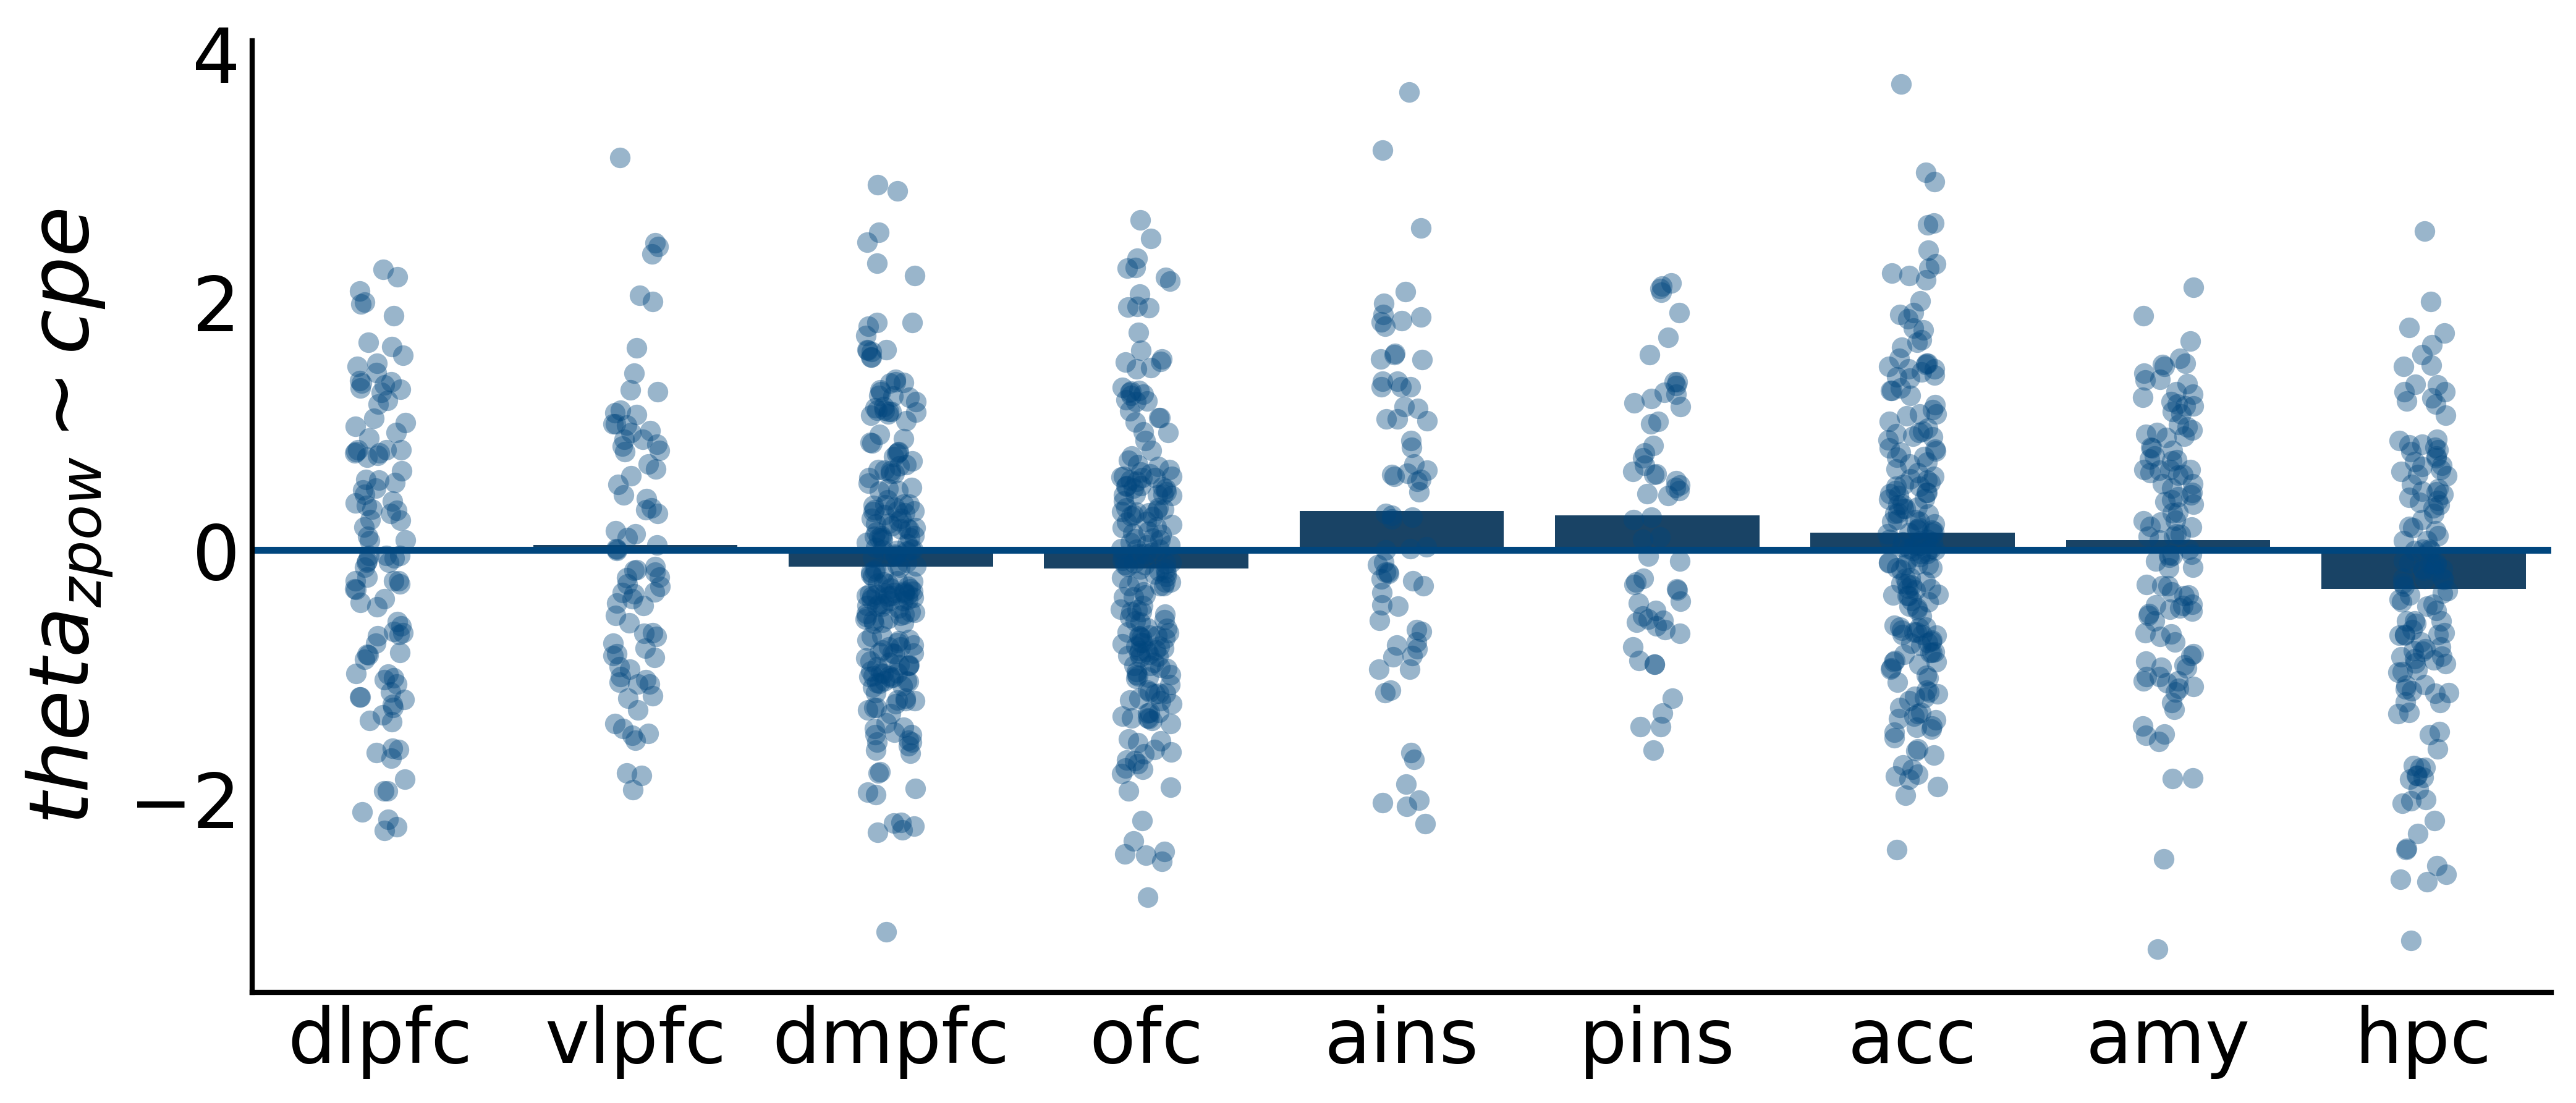

In [43]:

ylabel = fr'${band}_{{zpow}} \sim cpe$'
fig_id = f'{band}_mlm_roi_barplot_{epoch_len}.pdf'

plot_roi_model_results(results,'roi','Z_Score_cpe',bar_order=bar_order,figsize=(12,5),color='#00467e',
                       ylabel=ylabel,save_fig=True,save_dir=save_dir,fig_id=fig_id,dpi=400)



# BDI Correlation

In [44]:
# CHECK BDI CORRELATION

rho_data = []
sig_rho = []

# BDI CORRELATIONS
for roi in roi_fit_results.region_type.unique().tolist():
    roi_temp_data = roi_fit_results[roi_fit_results.region_type==roi]
    rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.cpe)
#     rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.elec_bCPE)
#     print(f'{roi} pearsonr',rho,rho_p)
    rho_data.append(pd.DataFrame({'roi':roi,'rho':rho,'rho_p':rho_p},index=[0]))
#     if rho_p <= bonferr_alpha:
#         sig_bdi_rois.append(roi)
#     if rho_p < bonferr_alpha:
    if rho_p < 0.05:
        sig_rho.append((roi,rho,rho_p))
    print(f'{roi} pearsonr',rho,rho_p)
rho_data = pd.concat(rho_data).reset_index(drop=True)


acc pearsonr -0.03824895908644217 0.5974209014931297
dmpfc pearsonr -0.01649547728403817 0.8056274623240299
amy pearsonr 0.08984917189933991 0.34394145391810577
ains pearsonr -0.21264906558267804 0.07500527288961897
vlpfc pearsonr -0.3780407747432753 0.00046238418001784827
hpc pearsonr -0.03324172547816048 0.7019064770901942
ofc pearsonr -0.053337837028055286 0.4509059676085028
pins pearsonr -0.16230587551183598 0.2153440804826463
dlpfc pearsonr 0.19966403581465303 0.03921796645995578


In [45]:
sig_rho

[('vlpfc', -0.3780407747432753, 0.00046238418001784827),
 ('dlpfc', 0.19966403581465303, 0.03921796645995578)]

In [46]:
### robust regression bdi ~ cpe coefficients
roi_rlm_dict = {}

for roi in roi_fit_results.region_type.unique().tolist():
    roi_df = roi_fit_results[roi_fit_results.region_type == roi]
    rlm = sm.RLM(roi_df.bdi.values, sm.add_constant(roi_df.cpe.values), M=sm.robust.norms.HuberT())
    rlm_results = rlm.fit()
    roi_rlm_dict[roi] = rlm_results
    print(roi)
    print(rlm_results.summary())




acc
                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                  193
Model:                            RLM   Df Residuals:                      191
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 25 Sep 2024                                         
Time:                        00:57:27                                         
No. Iterations:                    21                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.9421      0.460     34.628     

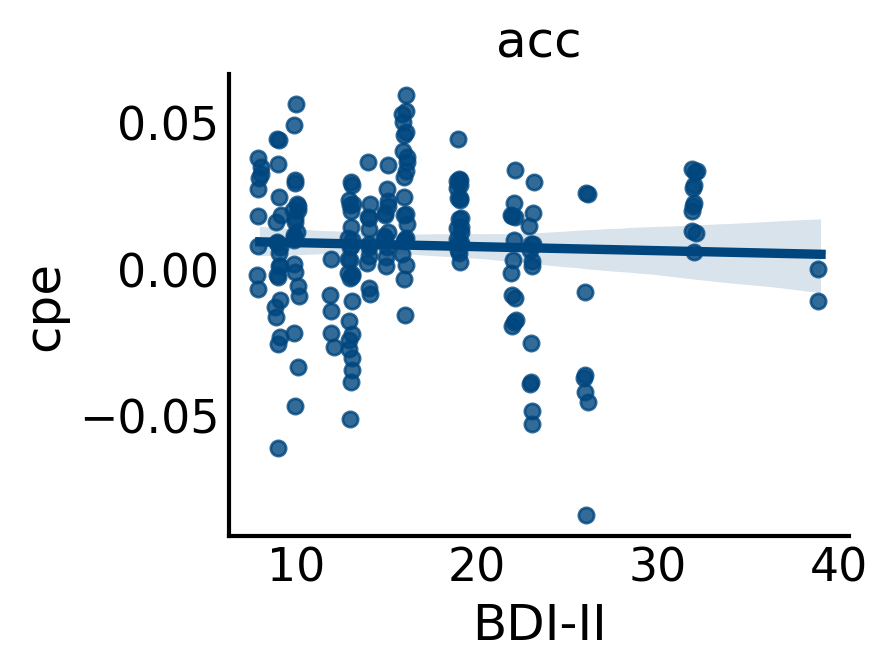

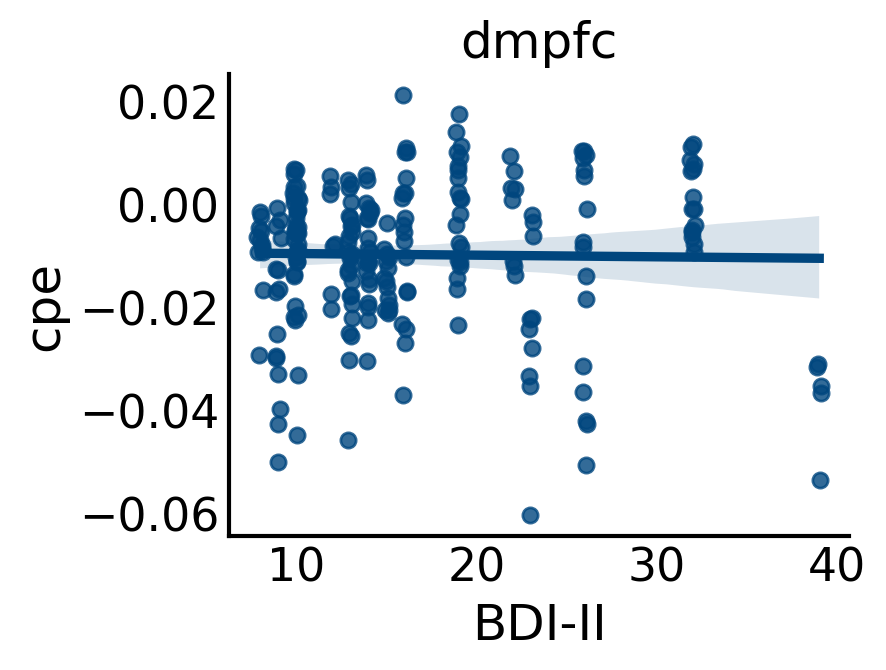

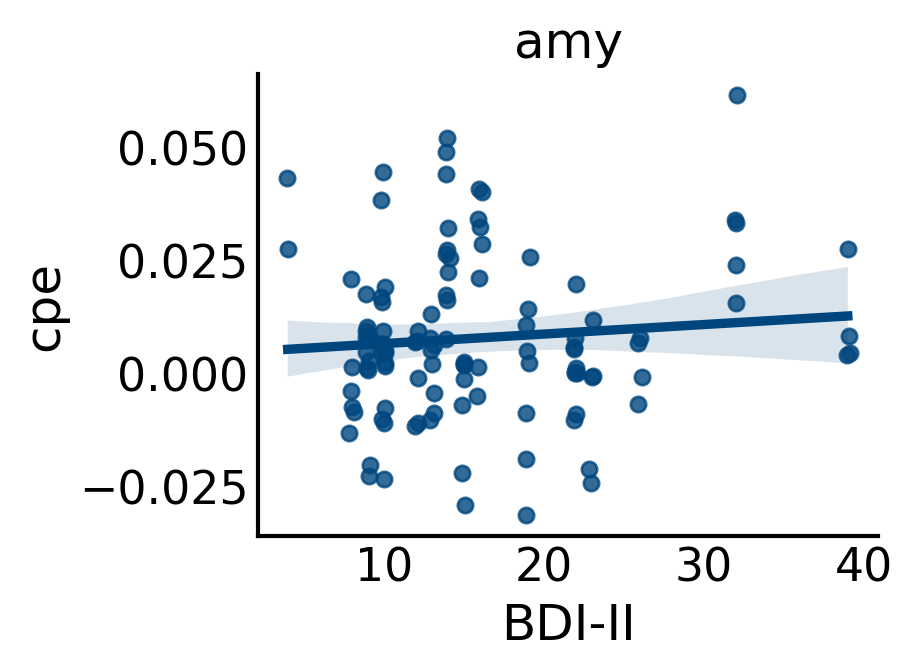

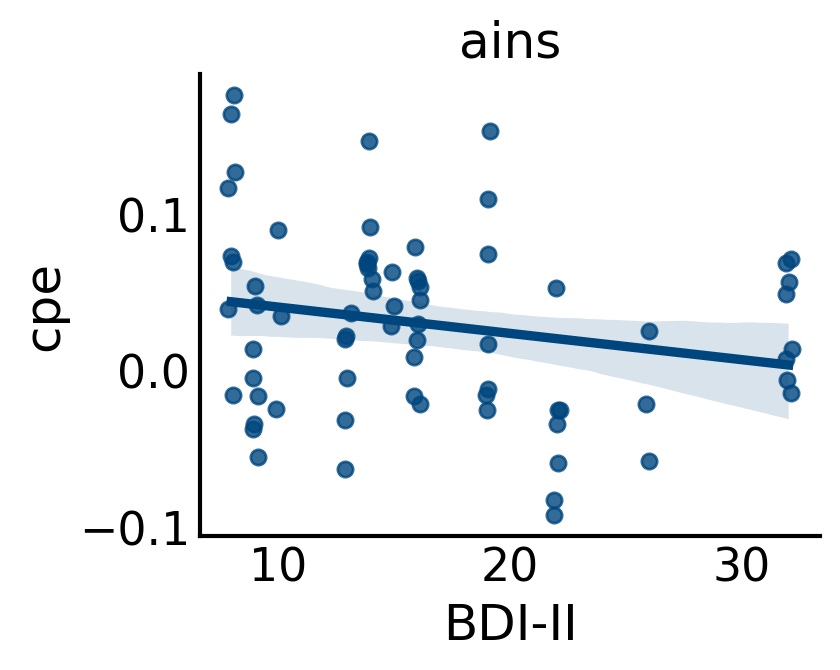

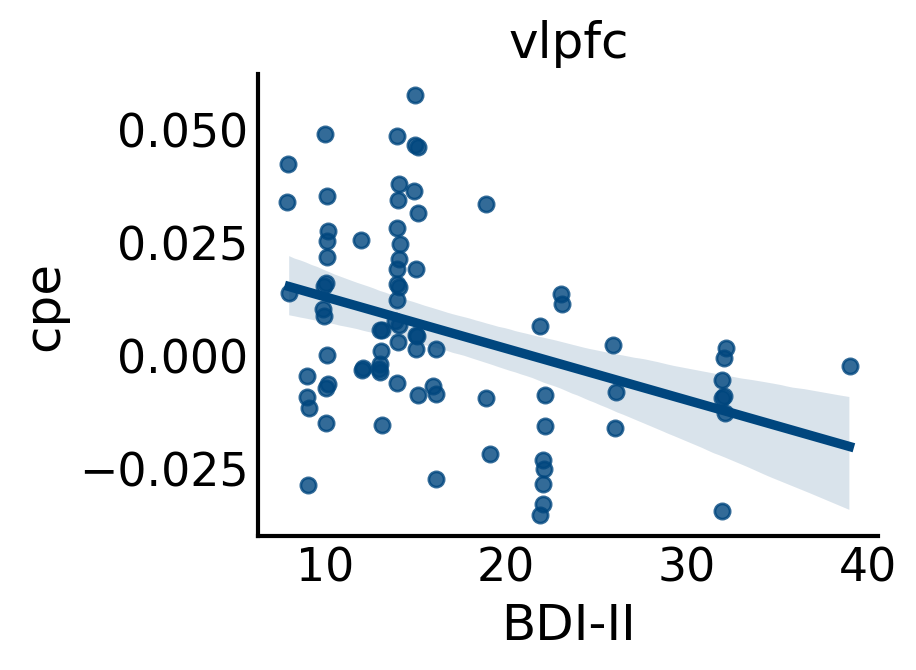

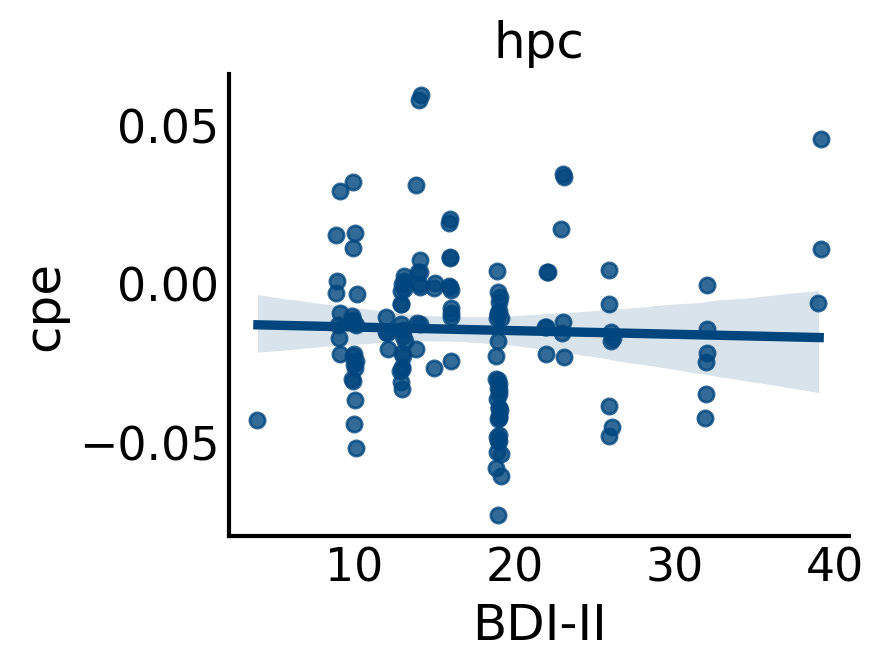

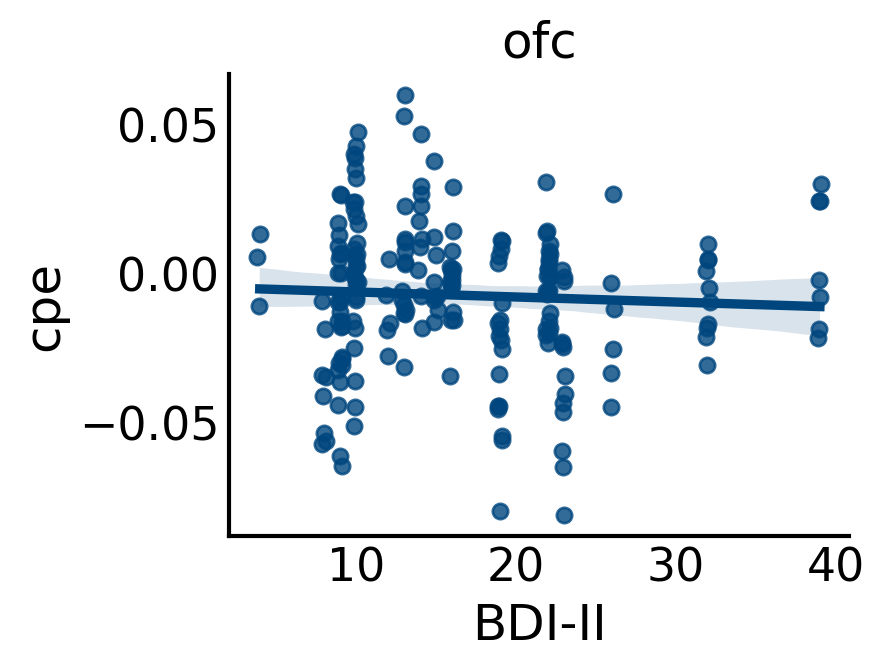

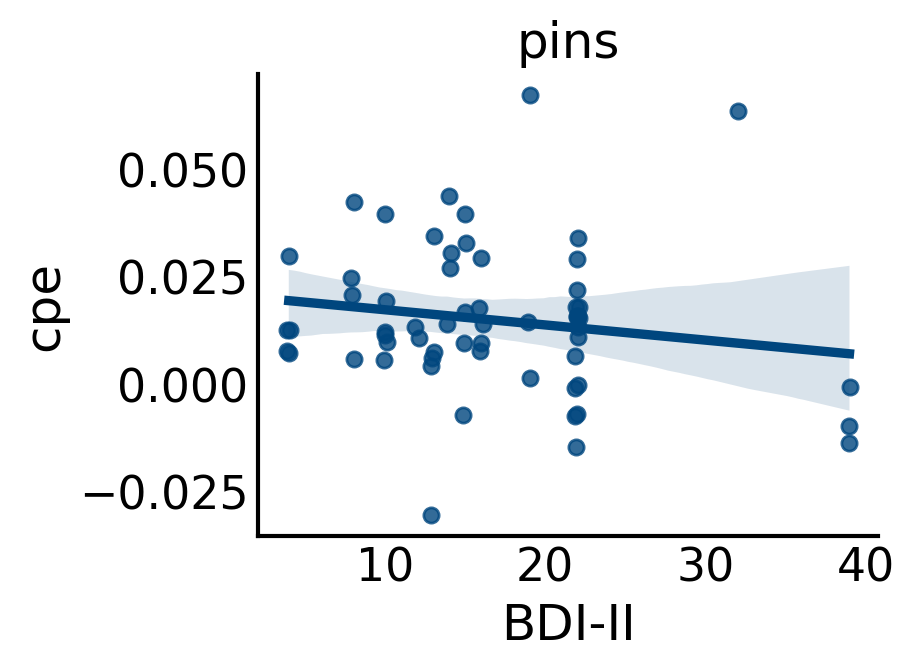

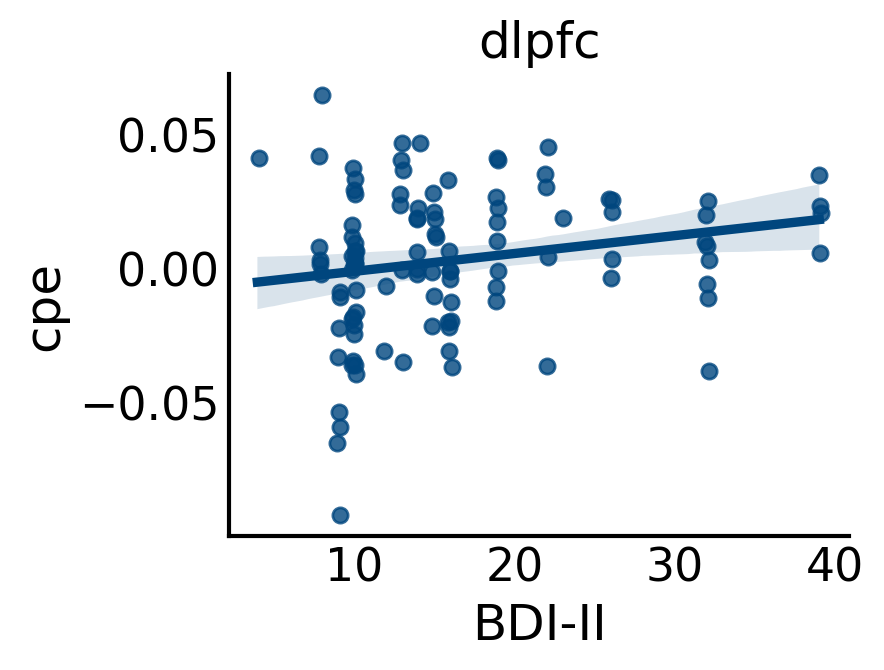

In [48]:

sns.set_context("talk",rc={'axes.linewidth': 1.5})

for roi in roi_fit_results.region_type.unique().tolist():
    
    roi_temp_data = roi_fit_results[roi_fit_results.region_type==roi]

#     rho   = rho_data[rho_data.roi == roi].round_rho.values[0]
#     rho_p = rho_data[rho_data.roi == roi].round_p.values[0]
    
        
    fig,ax = plt.subplots(1,1,figsize=(4,3),dpi=200)

    sns.regplot(data=roi_temp_data,x='bdi',y='cpe',scatter=True,ci=95,
                fit_reg=True,color = '#00467e',x_jitter = 0.15,scatter_kws={'s':30}) #034975
    
#     sns.scatterplot(data = roi_temp_data.groupby(['subj_id']).agg('mean'),x='bdi',
#                     y='decisionCPE',color = '#00467e',edgecolor=None,alpha=0.8)
    
#     plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 
    plt.xlabel('BDI-II')
#     plt.xlim([0,40])
    
    plt.tick_params(length=0) 
#     plt.ylabel('beta'+r'$beta_{{{zpow}}}$'+' cpe encoding')
#     plt.ylabel(fr'${band}_{{{zpow}}} \sim cpe$')

#     plt.text(np.max(roi_temp_data.bdi)-8,
#              np.round(np.max(roi_temp_data.groupby(['subj_id']).agg('mean').elec_bCPE),3)-0.003,
#              r'$rho$ = '+f'{rho} \n'+ fr'$p \approxeq $ {rho_p}',color='k',fontsize=12)
#              color='#00467e',fontsize=16)
#     plt.text(0.8,0.8,r'$rho$ = '+f'{rho} \n'+ fr'$p \approxeq $ {rho_p}',
#             verticalalignment='top', horizontalalignment='right',
#             color='k',fontsize=16)

    plt.title(f'{roi}')
    sns.despine()
#     plt.tight_layout()


    
#     sns.despine()
    
    plt.savefig(f'{fig_dir}/{band}_{roi}_{rho}_{rho_p}_roi_bdi-cpe-slope_{epoch_len}.pdf', format='pdf', metadata=None,
        bbox_inches='tight', pad_inches=0.1,dpi=300,
        facecolor='auto', edgecolor='auto',
        backend=None)
    

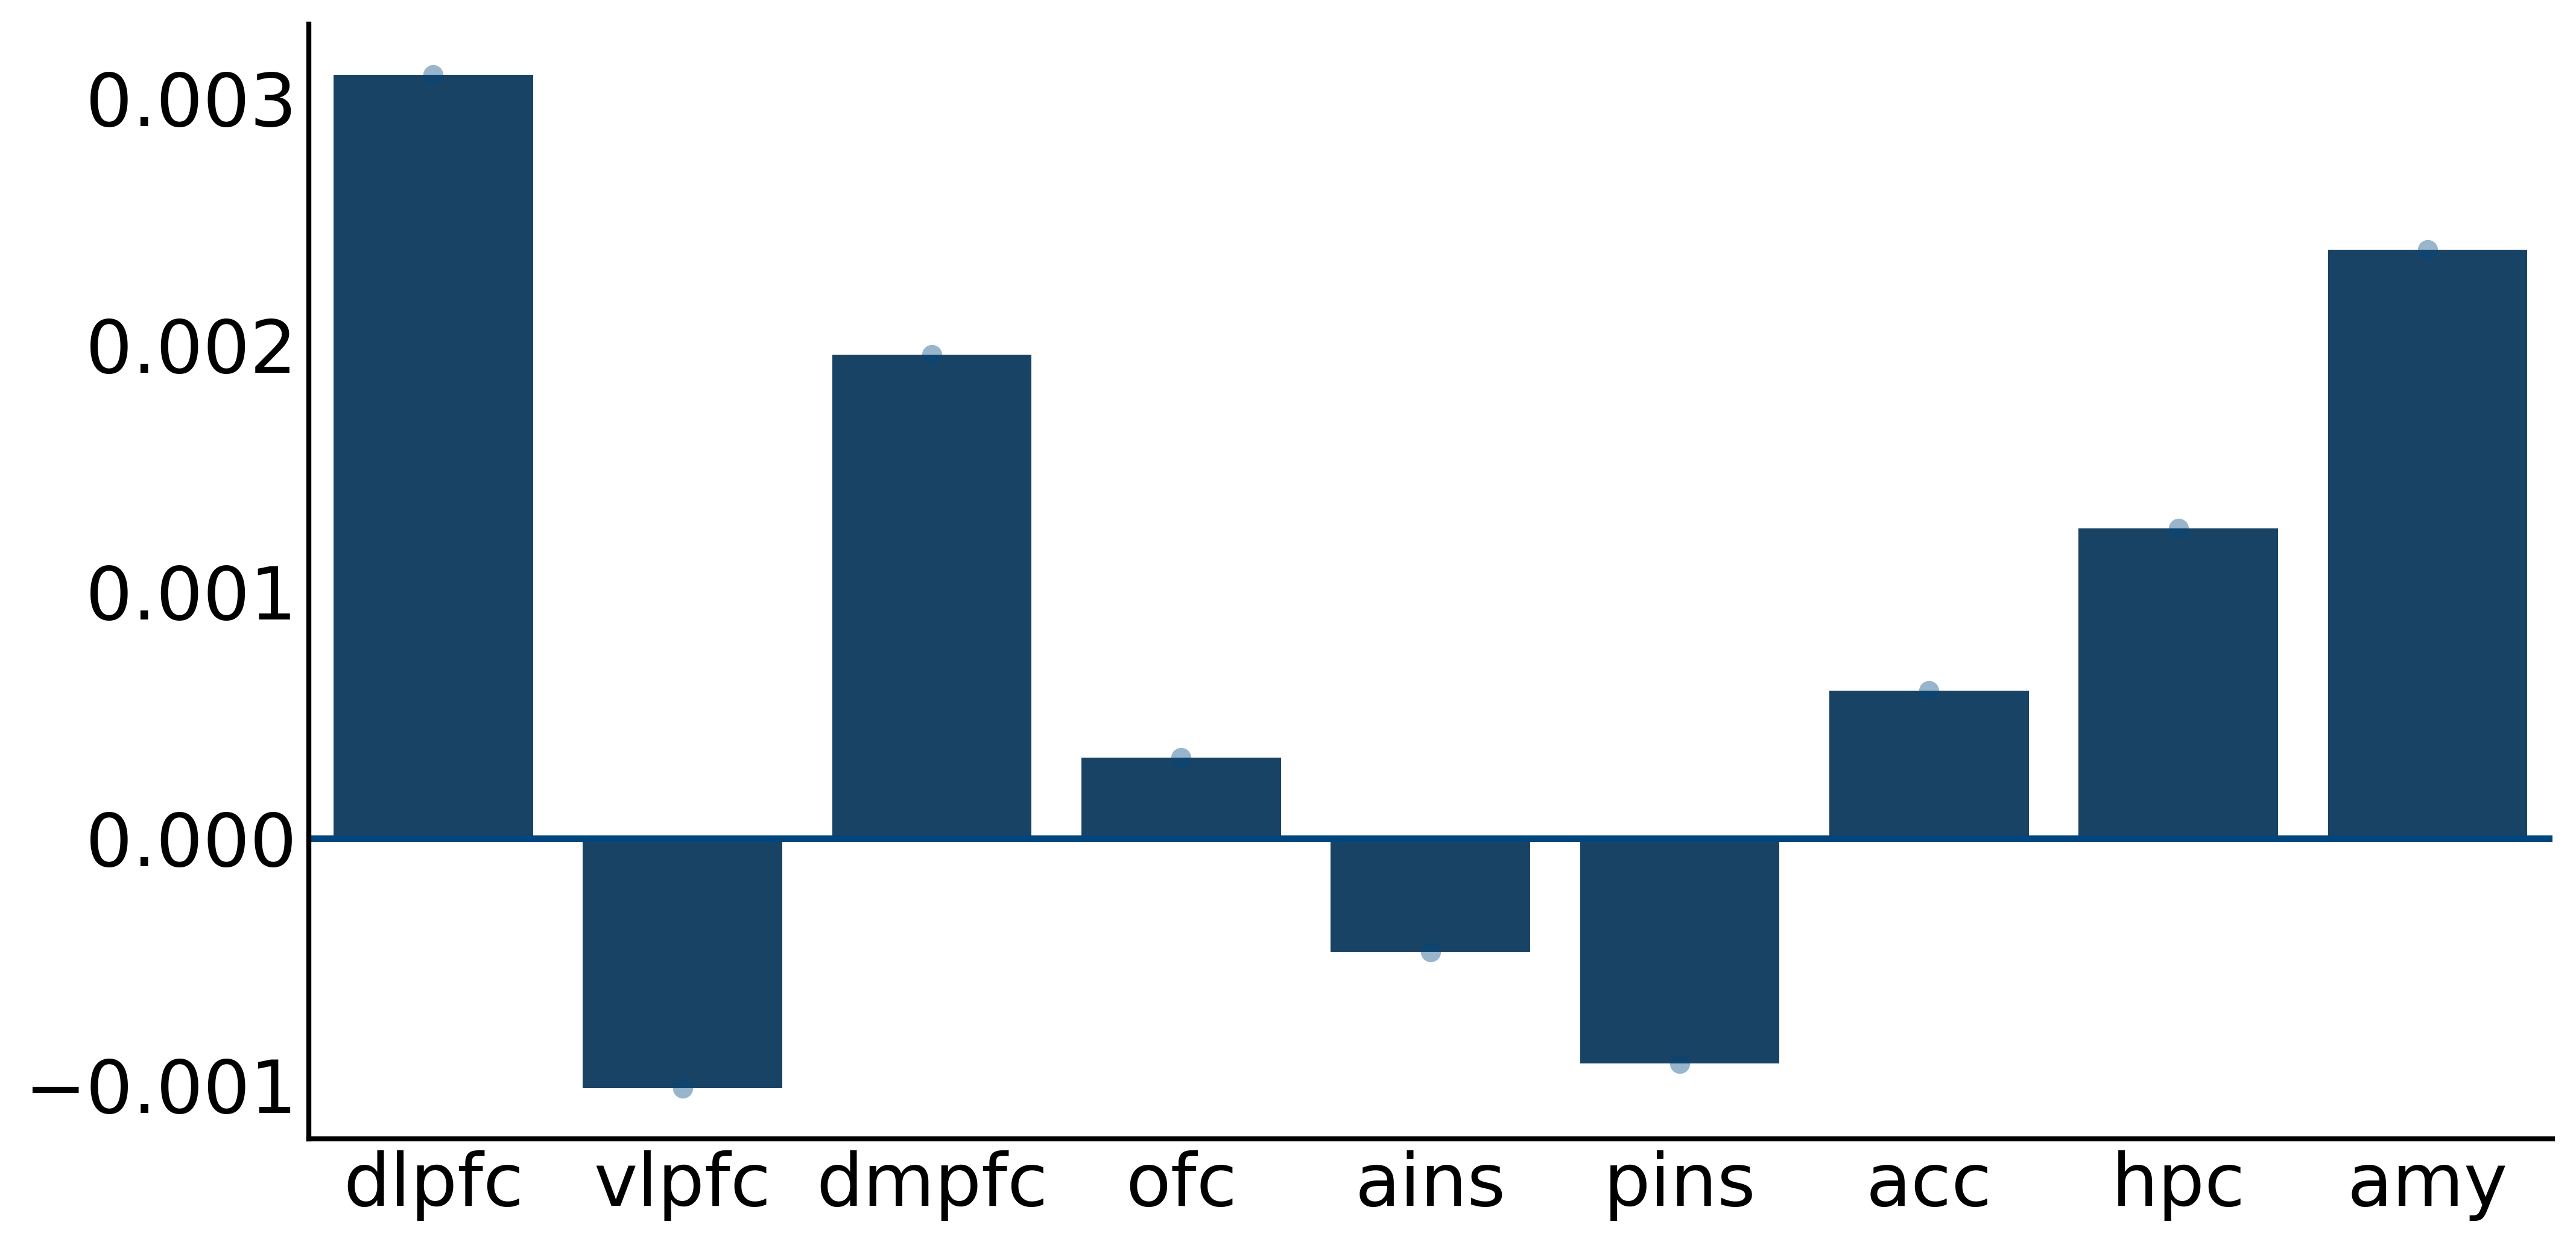

In [38]:
plot_roi_model_results(fe_results,'roi',"bdi:decisionCPE",bar_order=bar_order,figsize=(12,6),color='#00467e')
# add to slides 
